In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import nibabel as nib
from tqdm import tqdm
from pathlib import Path
import sys
import os
import shutil
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, roc_curve, auc, balanced_accuracy_score

In [2]:
tick_size = 20
matplotlib.rcParams.update({
    'figure.figsize':(10,10), 
    'font.size': 25, 
    "axes.labelsize":25, 
    "xtick.labelsize": tick_size, 
    "ytick.labelsize": tick_size,
    'font.family':'serif'
})

sns.set(rc={
    'figure.figsize':(10,10), 
    'font.size': 25, 
    "axes.labelsize":25, 
    "xtick.labelsize": tick_size, 
    "ytick.labelsize": tick_size,
    'font.family':'serif',
    'grid.linestyle': '',
    'axes.facecolor': 'white',
    'axes.edgecolor': '0.2',
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
})

palette = sns.color_palette("Set2", n_colors=6, desat=1)

In [3]:
def plot_ci(train_metrics, val_metrics, palette, metric_name=None):
    for i, (metrics, dataset_type) in enumerate(zip((train_metrics, val_metrics), ("Train", "Validation"))):
        upper_bound = min([len(m) for m in metrics])
        trimmed_metrics = [x[:upper_bound] for x in metrics]
        
        mean_metrics = np.mean(trimmed_metrics, axis=0)
        std_metrics = np.std(trimmed_metrics, axis=0)
        print("Avg std:", np.mean(std_metrics))
        plt.plot(mean_metrics, color=palette[i], label="{} {}".format(dataset_type, metric_name))
        plt.fill_between(range(len(mean_metrics)), 
                         mean_metrics - std_metrics, 
                         mean_metrics + std_metrics, 
                         alpha=0.2,
                         color=palette[i])

    plt.title("Training/Validation {} Curves".format(metric_name))
    plt.legend()
    plt.show()

In [4]:
def save_plot_ci(train_metrics, val_metrics, palette, metric_name=None, dst_dir=None):
    for i, (metrics, dataset_type) in enumerate(zip((train_metrics, val_metrics), ("Train", "Validation"))):
        upper_bound = min([len(m) for m in metrics])
        trimmed_metrics = [x[:upper_bound] for x in metrics]
        
        mean_metrics = np.mean(trimmed_metrics, axis=0)
        std_metrics = np.std(trimmed_metrics, axis=0)

        
        plt.plot(mean_metrics, color=palette[i], label="{} {}".format(dataset_type, metric_name))
        plt.fill_between(range(len(mean_metrics)), 
                         mean_metrics - std_metrics, 
                         mean_metrics + std_metrics, 
                         alpha=0.2,
                         color=palette[i])

    plt.title("Training/Validation {} Curves".format(metric_name))
    plt.legend()
    fname = metric_name.lower().replace(" ", "_") + ".png"
    plt.tight_layout()
    plt.savefig(dst_dir / fname)

In [5]:
MODEL_NAME = "phinet_3d"
RESULTS_DIR = Path("results") / MODEL_NAME
FIGURE_DIR = RESULTS_DIR / "figures"
ERROR_DIR = FIGURE_DIR / "errors"
for d in [FIGURE_DIR, ERROR_DIR]:
    if not d.exists():
        d.mkdir(parents=True)
training_curve_paths = sorted([x for x in RESULTS_DIR.iterdir() if 'training' in x.name])
testing_pred_paths = sorted([x for x in RESULTS_DIR.iterdir() if 'test' in x.name])

metrics = {
    "Loss": ('train_loss', 'val_loss'),
    "Accuracy": ('train_acc', 'val_acc')
  }

# Training Curves

In [8]:
training_curve_paths

[PosixPath('results/phinet_3d/training_curve_fold_0.csv')]

Avg std: 0.0
Avg std: 0.0


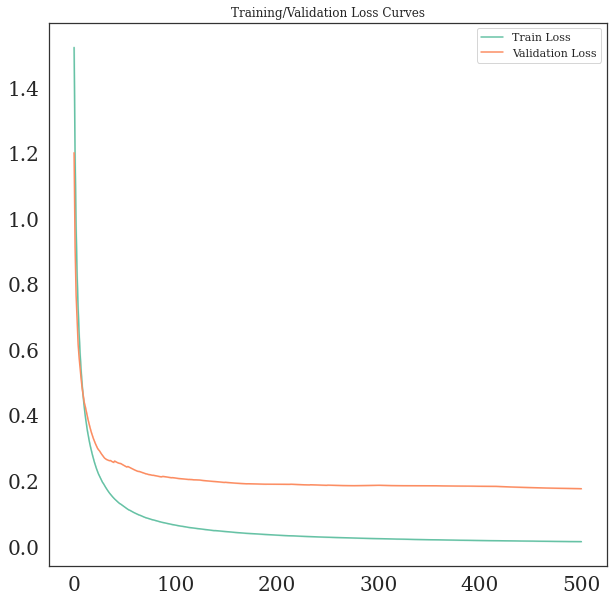

Avg std: 0.0
Avg std: 0.0


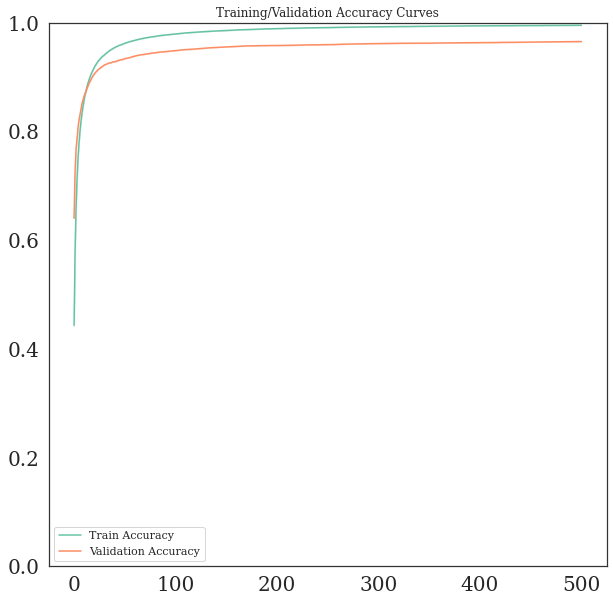

In [10]:
for metric_name, (train_metric, val_metric) in metrics.items():
        
        if "Accuracy" in metric_name:
            plt.ylim(0.0, 1.0)


        train_values = [pd.read_csv(str(tcp))[train_metric] for tcp in training_curve_paths]
        val_values = [pd.read_csv(str(tcp))[val_metric] for tcp in training_curve_paths]
        plot_ci(train_values, val_values, palette, metric_name)
        #save_plot_ci(train_values, val_values, palette, metric_name, FIGURE_DIR)
        plt.close()

In [11]:
# used in train, validation
dev_class_mapping = {
    0:"FL",
    1:"FLC",
    2:"PD",
    3:"T1",
    4:"T1C",
    5:"T2",
}

inv_dev_class_mapping = {v:k for k,v in dev_class_mapping.items()}

In [14]:
DATA_DIR = Path("data")

In [15]:
train_filename_files = sorted([x for x in DATA_DIR.iterdir() if "train_filenames" in x.name])
val_filename_files = sorted([x for x in DATA_DIR.iterdir() if "val_filenames" in x.name])
test_filename_files = sorted([x for x in DATA_DIR.iterdir() if "test_filenames" in x.name])

# Ensemble - Majority Voting

In [17]:
with open(test_filename_files[0], 'r') as f:
    lines = [l.strip().split(',') for l in f.readlines()]
fnames_labels = [(Path(s).resolve(), int(float(l))) for (s, l) in lines]

In [18]:
fnames_labels = sorted(set(fnames_labels))

In [19]:
ensemble_df = pd.DataFrame(fnames_labels, columns=['filename', 'true_class'])

In [20]:
ensemble_df.head()

,filename,true_class
0,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0
1,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0
2,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0
3,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0
4,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0


In [21]:
n_folds = 1
for cur_fold in range(n_folds):
    with open(str(testing_pred_paths[cur_fold])) as f:
        lines = [l.strip().split(',') for l in f.readlines()]
    df = pd.DataFrame(lines[1:], columns=lines[0])
    ensemble_df['fold_{}_pred_class'.format(cur_fold)] = df['pred_class'].copy()
    ensemble_df['fold_{}_pred_score'.format(cur_fold)] = df['pred_score'].copy()


In [22]:
ensemble_df.head()

,filename,true_class,fold_0_pred_class,fold_0_pred_score
0,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.00 0.86 0.00 0.05 0.09 0.00 ]
1,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]
2,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]
3,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]
4,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]


In [24]:
def ensemble_prediction(row):
    preds = ['fold_{}_pred_class'.format(i) for i in range(5)]
    mode_class = row[preds].dropna().astype(int).mode()
    if len(mode_class) < 1:
        impute_value= np.nan
    else:
        impute_value = int(row[preds].dropna().astype(int).mode()[0])
    return impute_value

def parse_score(score_str):
    return np.array(list(map(lambda x: np.float32(x), score_str[1:-1].split())), dtype=np.float32)

def ensemble_pred_score(row):
    score_keys = ['fold_{}_pred_score'.format(i) for i in range(5)]
    scores = np.array([parse_score(row[s]) for s in score_keys])
    mean_scores = np.mean(scores, axis=0)
    
    return mean_scores

In [25]:
ensemble_df.head()

,filename,true_class,fold_0_pred_class,fold_0_pred_score
0,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.00 0.86 0.00 0.05 0.09 0.00 ]
1,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]
2,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]
3,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]
4,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]


In [26]:
ensemble_df['ensemble_pred'] = ensemble_df.apply(lambda row: ensemble_prediction(row), axis=1)
ensemble_df['ensemble_score'] = ensemble_df.apply(lambda row: ensemble_pred_score(row), axis=1)

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [27]:
ensemble_df.head()

,filename,true_class,fold_0_pred_class,fold_0_pred_score
0,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.00 0.86 0.00 0.05 0.09 0.00 ]
1,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]
2,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]
3,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]
4,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]


In [33]:
##### CONFUSION MATRIX #####

class_names = sorted(dev_class_mapping.values())


cm = confusion_matrix(
    ensemble_df['true_class'].astype(int), 
    ensemble_df['fold_0_pred_class'].astype(int),
)


cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='True Label',
    xlabel='Predicted Label',
)

ax.xaxis.labelpad = 25
ax.yaxis.labelpad = 25

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
#plt.setp(ax.get_yticklabels(), rotation=90, ha='center', rotation_mode='anchor')

thresh = cm_norm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        
        if cm[i, j] == 0:
            cell_str = "{}".format(cm[i, j])
        else:
            cell_str = "{}\n{:.2%}".format(cm[i, j], cm_norm[i, j])
        ax.text(j, i, cell_str,
                ha="center", va="center",
                color="white" if cm_norm[i, j] > thresh else 'black',
                fontsize=18)
fig.tight_layout()
#plt.show()
plt.savefig(FIGURE_DIR / "normalized_ensembled_confusion_matrix.png")
plt.close()


In [29]:
print("{}/{} = {:.2%} accuracy".format(
    np.diag(cm).sum(),
    np.array(cm).sum(),
    np.diag(cm).sum() / np.array(cm).sum(),
))

1941/1990 = 97.54% accuracy


In [32]:
print("Balanced accuracy score: {:.2%}".format(
    balanced_accuracy_score(
        ensemble_df['true_class'].astype(int),
        ensemble_df['fold_0_pred_class'].astype(int),
    )
))

Balanced accuracy score: 96.70%


# Examining Errors

In [34]:
ensemble_df.head()

,filename,true_class,fold_0_pred_class,fold_0_pred_score
0,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.00 0.86 0.00 0.05 0.09 0.00 ]
1,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]
2,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]
3,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]
4,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,0,[1.00 0.00 0.00 0.00 0.00 0.00 ]


In [38]:
error_df = ensemble_df[ensemble_df['true_class'] != ensemble_df['fold_0_pred_class'].astype(int)]

In [39]:
len(error_df)

49

In [40]:
error_df

,filename,true_class,fold_0_pred_class,fold_0_pred_score
0,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.00 0.86 0.00 0.05 0.09 0.00 ]
5,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.00 1.00 0.00 0.00 0.00 0.00 ]
16,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.04 0.96 0.00 0.00 0.00 0.00 ]
32,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.16 0.84 0.00 0.00 0.00 0.00 ]
38,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.00 1.00 0.00 0.00 0.00 0.00 ]
40,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.00 1.00 0.00 0.00 0.00 0.00 ]
41,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.00 1.00 0.00 0.00 0.00 0.00 ]
44,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.00 1.00 0.00 0.00 0.00 0.00 ]
48,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.40 0.60 0.00 0.00 0.00 0.00 ]
49,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,0,1,[0.22 0.78 0.00 0.00 0.00 0.00 ]


In [42]:
error_df[['filename', 'fold_0_pred_score']]

,filename,fold_0_pred_score
0,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,[0.00 0.86 0.00 0.05 0.09 0.00 ]
5,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,[0.00 1.00 0.00 0.00 0.00 0.00 ]
16,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,[0.04 0.96 0.00 0.00 0.00 0.00 ]
32,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,[0.16 0.84 0.00 0.00 0.00 0.00 ]
38,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,[0.00 1.00 0.00 0.00 0.00 0.00 ]
40,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,[0.00 1.00 0.00 0.00 0.00 0.00 ]
41,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,[0.00 1.00 0.00 0.00 0.00 0.00 ]
44,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,[0.00 1.00 0.00 0.00 0.00 0.00 ]
48,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,[0.40 0.60 0.00 0.00 0.00 0.00 ]
49,/ISFILE3/USERS/roys5/Identify_Contrast/remove_...,[0.22 0.78 0.00 0.00 0.00 0.00 ]


In [57]:
np.mean(error_df['fold_0_pred_score'])

TypeError: Could not convert [0.00 0.86 0.00 0.05 0.09 0.00 ][0.00 1.00 0.00 0.00 0.00 0.00 ][0.04 0.96 0.00 0.00 0.00 0.00 ][0.16 0.84 0.00 0.00 0.00 0.00 ][0.00 1.00 0.00 0.00 0.00 0.00 ][0.00 1.00 0.00 0.00 0.00 0.00 ][0.00 1.00 0.00 0.00 0.00 0.00 ][0.00 1.00 0.00 0.00 0.00 0.00 ][0.40 0.60 0.00 0.00 0.00 0.00 ][0.22 0.78 0.00 0.00 0.00 0.00 ][0.01 0.99 0.00 0.00 0.00 0.00 ][0.14 0.86 0.00 0.00 0.00 0.00 ][0.00 0.00 0.00 1.00 0.00 0.00 ][0.01 0.99 0.00 0.00 0.00 0.00 ][0.19 0.81 0.00 0.00 0.00 0.00 ][0.34 0.66 0.00 0.00 0.00 0.00 ][0.00 0.00 0.00 0.99 0.00 0.00 ][0.02 0.00 0.00 0.98 0.00 0.00 ][0.00 1.00 0.00 0.00 0.00 0.00 ][0.16 0.84 0.00 0.00 0.00 0.00 ][0.01 0.99 0.00 0.00 0.00 0.00 ][0.32 0.68 0.00 0.00 0.00 0.00 ][0.15 0.85 0.00 0.00 0.00 0.00 ][0.15 0.85 0.00 0.00 0.00 0.00 ][0.00 1.00 0.00 0.00 0.00 0.00 ][0.12 0.88 0.00 0.00 0.00 0.00 ][0.02 0.95 0.00 0.00 0.02 0.00 ][0.00 1.00 0.00 0.00 0.00 0.00 ][0.21 0.79 0.00 0.00 0.00 0.00 ][0.49 0.50 0.00 0.00 0.00 0.00 ][0.25 0.75 0.00 0.00 0.00 0.00 ][0.70 0.29 0.00 0.00 0.00 0.00 ][1.00 0.00 0.00 0.00 0.00 0.00 ][1.00 0.00 0.00 0.00 0.00 0.00 ][0.99 0.01 0.00 0.00 0.00 0.00 ][0.53 0.42 0.05 0.00 0.00 0.00 ][0.06 0.24 0.00 0.01 0.69 0.00 ][0.98 0.02 0.00 0.00 0.00 0.00 ][0.90 0.10 0.00 0.00 0.00 0.00 ][0.75 0.02 0.03 0.00 0.20 0.00 ][0.00 0.07 0.00 0.00 0.93 0.00 ][0.00 0.00 0.49 0.00 0.51 0.00 ][0.00 0.00 0.92 0.08 0.00 0.00 ][0.00 0.06 0.00 0.00 0.94 0.00 ][0.00 0.96 0.00 0.04 0.00 0.00 ][0.00 0.00 0.99 0.01 0.00 0.00 ][0.99 0.00 0.01 0.00 0.00 0.00 ][0.43 0.54 0.00 0.00 0.00 0.03 ][0.98 0.00 0.00 0.00 0.00 0.02 ] to numeric

In [44]:
for row in error_df.iterrows():
    TEMPLATE = "{}\nFL: {:.0%} FLC: {:.0%} PD: {:.0%} T1: {:.0%} T1C: {:.0%} T2: {:.0%}\n"

    fname = Path(row[1]['filename']).name
    
    scores = [s for s in row[1]['fold_0_pred_score']]
        
    print(TEMPLATE.format(
        fname,
        *scores,
    ))

ValueError: Unknown format code '%' for object of type 'str'

In [77]:
def get_spaced_slices(num_slices, num_plots, offset):
    t = (num_slices-(offset*2)) // num_plots
    return [x for x in range(offset, num_slices-offset, t)]

In [52]:
def annot_figure(row, num_figs, offset, class_mapping, fig_dir):
    x = nib.load(row['filename']).get_fdata()
    
    side = int(np.sqrt(num_figs))
    fig, axs = plt.subplots(
        side, 
        side,
    )
    

    plt.suptitle("True: {} | Pred: {}".format(
                class_mapping[row['true_class']],
                class_mapping[row['fold_0_pred_class']],
            ),
                y = 0.925
        )
    
    spaced_slices = get_spaced_slices(x.shape[-1], num_figs, offset)
    c = 0
    for i in range(side):
        for j in range(side):
            axs[i, j].imshow(x[:, :, spaced_slices[c]].T, cmap='Greys_r', vmin=0.0, vmax=255.0)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            c += 1
            
    details_str = "Image details\nShape: {}\nMax: {:.2f}\nMin: {:.2f}\nMean: {:.2f}".format(
        x.shape, x.max(), x.min(), x.mean()
    )
            
    plt.text(
        -1.2, 0.0, 
        details_str, 
        fontsize=16,
        horizontalalignment='center',
        verticalalignment='center', 
        transform=axs[0,0].transAxes
    )
    
    gap = 1e-4
    plt.subplots_adjust(wspace=gap, hspace=gap)
    
    fig_class_dir = fig_dir / dev_class_mapping[row['true_class']]
    if not fig_class_dir.exists():
        fig_class_dir.mkdir(parents=True)

    figure_name = fig_class_dir / "annotated_montage_{}.png".format(Path(row['filename']).stem.split('.')[0])
    print(figure_name)
    #plt.savefig(figure_name, bbox_inches="tight")
    plt.show()
    plt.close()

In [53]:
error_df.iloc[0]['filename']

PosixPath('/ISFILE3/USERS/roys5/Identify_Contrast/remove_bg_noise/denoised/approxdef/FL/03-2054_0a_0007_FLAIR_approxdef_denoised.nii.gz')

KeyError: '1'

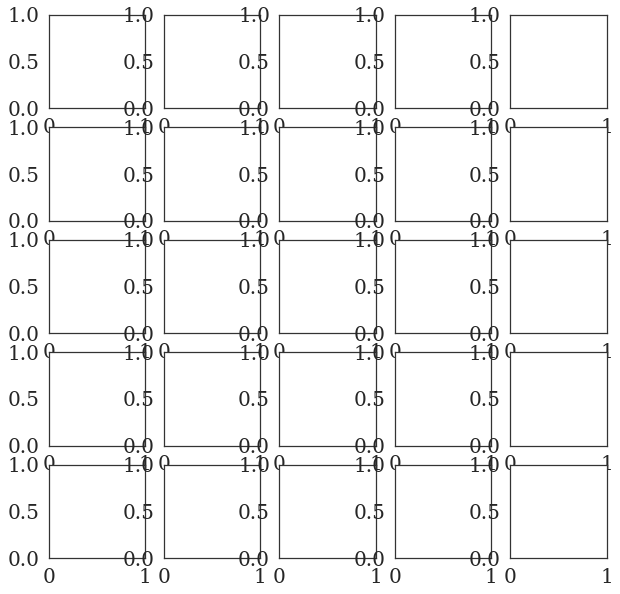

In [54]:
for row in error_df.iterrows():
    annot_figure(row[1], 25, 10, dev_class_mapping, ERROR_DIR)